In [62]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *
from analysis import *

import sys
sys.path.append(constants.GRANTHAM_DISTANCE_PATH)

import grantham_distance as gd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
from tqdm.notebook import tqdm

In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
loaded = False

# Load BioBank Components

In [4]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    (biobank_data_no_HLA_alleles, biobank_index,
     med_code_mapping) = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 376 features.
UK BioBank Data Loaded.
Size: 502536 rows x 376 columns
Elapsed time: 130.1519 seconds


Mapping Medical Codes:   0%|          | 0/361 [00:00<?, ? feature/s]

# All illnesses

In [5]:
data = biobank_data.sample(10000)

In [6]:
illness_codes = [feature for feature in biobank_data.columns if get_base_feature(feature) == "illness_code"]
all_illnesses = biobank_data[illness_codes].values.ravel()
all_illnesses, counts = np.unique(all_illnesses[~pd.isnull(all_illnesses)], return_counts=True)

In [7]:
illness_dict = {}
for illness in tqdm(all_illnesses):
    illness_dict[illness] = get_illness_value(data, illness, "illness_code")

  0%|          | 0/444 [00:00<?, ?it/s]

In [8]:
illness_data = pd.concat([data[["eid", "sex", "birth_year"]], pd.DataFrame(illness_dict)], axis=1)

In [9]:
illness_graph = np.zeros((len(all_illnesses), len(all_illnesses)))

In [10]:
for i, illness in enumerate(all_illnesses):
    illness_values = illness_data[illness].values
    for j, associated_illness in enumerate(all_illnesses):
        illness_graph[i, j] = np.sum(illness_values & illness_data[associated_illness].values)

In [11]:
unique_edge_weights = illness_graph[np.triu_indices(len(illness_graph))]
unique_edge_weights = unique_edge_weights[unique_edge_weights != 0]

/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

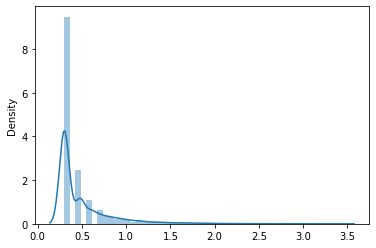

In [12]:
sns.distplot(np.log10(unique_edge_weights + 1))

In [13]:
df = pd.DataFrame(illness_graph, columns=all_illnesses)
df.index = all_illnesses
df

,abdominal hernia,abnormal smear (cervix),acne/acne vulgaris,acromegaly,acute infective polyneuritis/guillain-barre syndrome,adrenal tumour,adrenocortical insufficiency/addison's disease,alcohol dependency,alcoholic liver disease / alcoholic cirrhosis,allergy or anaphylactic reaction to drug,...,varicose veins,vasculitis,venous thromboembolic disease,vertigo,vitiligo,vocal cord polyp,wegners granulmatosis,whooping cough / pertussis,wolff parkinson white / wpw syndrome,yellow fever
abdominal hernia,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abnormal smear (cervix),0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acne/acne vulgaris,1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acromegaly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acute infective polyneuritis/guillain-barre syndrome,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vocal cord polyp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
wegners granulmatosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
whooping cough / pertussis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0
wolff parkinson white / wpw syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


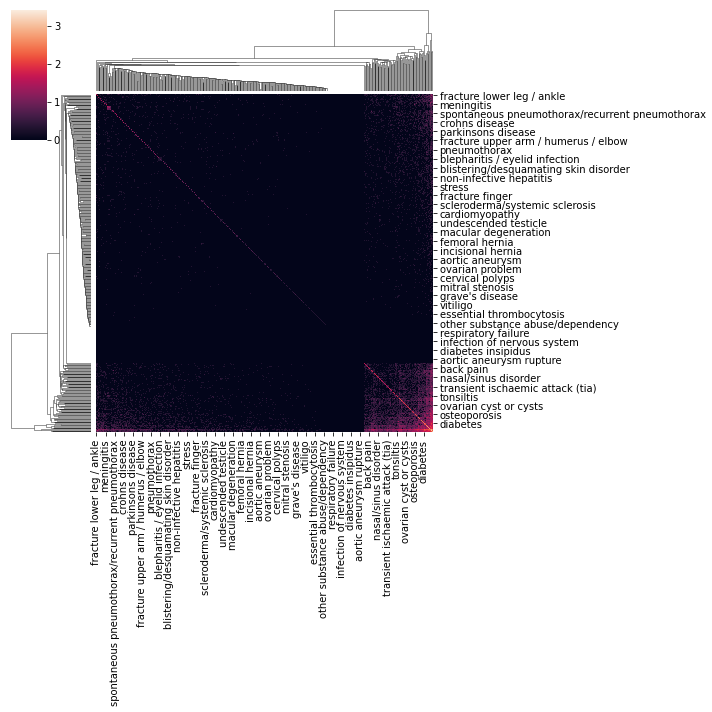

In [14]:
sns.clustermap(np.log10(df + 1))

In [127]:
from analysis import *

(0.741175386969822, 0.00016883926887726445)

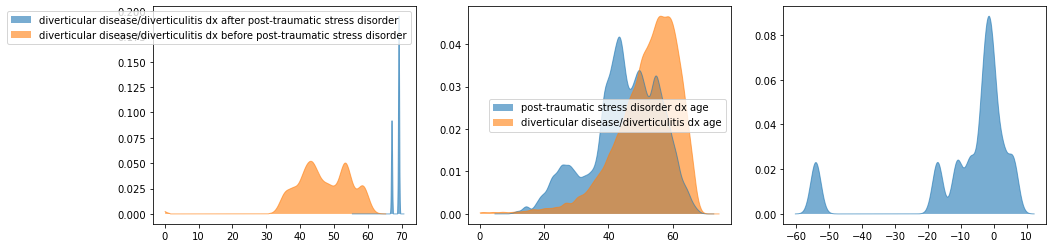

In [183]:
precursor_illness = "post-traumatic stress disorder"
illness = "diverticular disease/diverticulitis"

_, precursor_dx_ages = get_illness_value_dx_age(biobank_data, precursor_illness, "illness_code")
_, illness_dx_ages = get_illness_value_dx_age(biobank_data, illness, "illness_code")

precursor_before_illness = illness_dx_ages > precursor_dx_ages
precursor_values, illness_values = precursor_dx_ages >= 0, illness_dx_ages >= 0

fig, (a0, a1, a2) = plt.subplots(figsize=(16, 4), ncols=3)
params = dict(bw=0.1, clip=(0, None))
kde_plot(illness_dx_ages[precursor_values & precursor_before_illness],
         label=f"{illness} dx after {precursor_illness}", ax=a0, **params)
kde_plot(illness_dx_ages[precursor_values & ~precursor_before_illness & illness_values],
         label=f"{illness} dx before {precursor_illness}", ax=a0, **params)
kde_plot(precursor_dx_ages[precursor_values], label=f"{precursor_illness} dx age", ax=a1, clip=clip, bw=bw)
kde_plot(illness_dx_ages[illness_values], label=f"{illness} dx age", ax=a1, clip=clip, bw=bw)
kde_plot((illness_dx_ages - precursor_dx_ages)[precursor_values & illness_values], bw=bw, ax=a2)

preceding_event_test(precursor_dx_ages, illness_dx_ages)

In [188]:
np.random.seed(6)
some_illnesses_raw = sorted(np.random.choice(all_illnesses, 50))
some_illnesses_raw = all_illnesses

illness_dx_data = {}
for illness in tqdm(some_illnesses_raw, desc="Aggregating illness dates", unit=" illnesses"):
    new_illness_label = illness.replace(" ", "_")
    _, illness_dx_age = get_illness_value_dx_age(biobank_data, illness, "illness_code")
    illness_dx_data[new_illness_label] = illness_dx_age

illness_dx_data = pd.DataFrame(illness_dx_data)
some_illnesses = list(illness_dx_data.columns)

Aggregating illness dates:   0%|          | 0/444 [00:00<?, ? illnesses/s]

In [ ]:
preceding_tests = []

pbar = tqdm(total=len(some_illnesses) ** 2, unit=" illnesses")


for illness in some_illnesses:
    illness_preceding_tests = []
    for precursor_illness in some_illnesses:
        if precursor_illness == illness:
            illness_preceding_tests.append(1)
        else:
            precursor_dx_ages, illness_dx_ages = illness_dx_data[precursor_illness], illness_dx_data[illness].values
            p, r = preceding_event_test(precursor_dx_ages, illness_dx_ages)
            illness_preceding_tests.append(r)
        pbar.update(1)

    preceding_tests.append(illness_preceding_tests)
pbar.close()

preceding_tests = pd.DataFrame(preceding_tests, columns=some_illnesses)
preceding_tests.index = some_illnesses

  0%|          | 0/197136 [00:00<?, ? illnesses/s]

In [185]:
preceding_tests

,abnormal_smear_(cervix),alopecia_/_hair_loss,aortic_aneurysm_rupture,aplastic_anaemia,benign_breast_lump,brain_abscess/intracranial_abscess,bronchiectasis,cervical_polyps,cholecystitis,chronic_sinusitis,...,polycystic_kidney,post-traumatic_stress_disorder,retinal_artery/vein_occlusion,retinitis_pigmentosa,spinal_injury,stomach_disorder,thyroiditis,type_1_diabetes,urticaria,varicose_ulcer
abnormal_smear_(cervix),1.000000,NaN,NaN,NaN,0.286280,NaN,NaN,0.639997,NaN,0.704815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alopecia_/_hair_loss,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aortic_aneurysm_rupture,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aplastic_anaemia,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
benign_breast_lump,0.403642,NaN,NaN,NaN,1.000000,NaN,0.312241,0.655643,1.000000,0.548124,...,NaN,NaN,NaN,NaN,NaN,0.555827,NaN,NaN,0.643975,NaN
brain_abscess/intracranial_abscess,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bronchiectasis,NaN,NaN,NaN,NaN,0.312556,NaN,1.000000,NaN,1.000000,0.252374,...,NaN,NaN,NaN,NaN,NaN,0.625203,NaN,NaN,NaN,NaN
cervical_polyps,0.031314,NaN,NaN,NaN,0.656897,NaN,NaN,1.000000,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cholecystitis,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,1.000000,0.494640,...,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
chronic_sinusitis,0.705461,NaN,NaN,NaN,0.547541,NaN,0.744635,0.558226,0.493474,1.000000,...,NaN,0.556948,0.399661,NaN,1.000000,0.352329,NaN,NaN,NaN,NaN


In [186]:
for col in preceding_tests.columns:
    for index in preceding_tests.index:
        if preceding_tests.loc[index, col] < 0.05:
            print(col, " -> ",  index, preceding_tests.loc[index, col])

abnormal_smear_(cervix)  ->  cervical_polyps 0.03131350553006992
bronchiectasis  ->  diverticular_disease/diverticulitis 0.009395194586589262
bronchiectasis  ->  emphysema/chronic_bronchitis 0.00041423470686555717
diabetic_eye_disease  ->  type_1_diabetes 0.004695520553244407
disc_degeneration  ->  kidney_stone/ureter_stone/bladder_stone 0.04705359724509105
diverticular_disease/diverticulitis  ->  fracture_shoulder_/_scapula 0.03549680249016775
diverticular_disease/diverticulitis  ->  peritonitis 0.04336359928240037
diverticular_disease/diverticulitis  ->  post-traumatic_stress_disorder 0.0014534726120325704
diverticular_disease/diverticulitis  ->  stomach_disorder 0.04034470838692865
emphysema/chronic_bronchitis  ->  helicobacter_pylori 0.012638736093787913
emphysema/chronic_bronchitis  ->  peripheral_neuropathy 0.03701686504466292
emphysema/chronic_bronchitis  ->  spinal_injury 0.03651671133772851
endometriosis  ->  abnormal_smear_(cervix) 0.03216442658907521
endometriosis  ->  gynae

In [187]:
significant = preceding_tests.loc[preceding_tests.lt(0.05).any(axis=1), preceding_tests.lt(0.05).any()]
significant

,abnormal_smear_(cervix),bronchiectasis,diabetic_eye_disease,disc_degeneration,diverticular_disease/diverticulitis,emphysema/chronic_bronchitis,endometriosis,epilepsy,fracture_shoulder_/_scapula,helicobacter_pylori,kidney_stone/ureter_stone/bladder_stone,peripheral_neuropathy,peritonitis,pneumothorax,post-traumatic_stress_disorder,retinal_artery/vein_occlusion,spinal_injury,stomach_disorder,type_1_diabetes
abnormal_smear_(cervix),1.000000,NaN,NaN,0.681363,0.476487,0.672741,0.032164,1.000000,NaN,0.428107,0.559772,NaN,5.318664e-01,NaN,NaN,NaN,NaN,NaN,NaN
brain_abscess/intracranial_abscess,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bronchiectasis,NaN,1.000000,NaN,NaN,0.050059,0.126364,1.000000,0.049644,NaN,0.087650,1.000000,0.656666,1.000000e+00,0.561698,NaN,NaN,NaN,0.625203,NaN
cervical_polyps,0.031314,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.129403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diabetic_eye_disease,NaN,NaN,1.000000,1.000000,0.299602,0.854162,0.605338,0.378367,NaN,NaN,0.772616,0.168129,1.000000e+00,0.426718,NaN,1.000000,0.234477,0.053871,0.027045
disc_degeneration,0.681443,NaN,1.000000,1.000000,0.491924,0.301761,0.203884,0.693902,0.250672,0.208331,0.047770,0.422406,3.907115e-01,NaN,1.000000,NaN,1.000000,NaN,NaN
diverticular_disease/diverticulitis,0.479248,0.009395,0.300520,0.494186,1.000000,0.616486,0.200101,0.108309,0.036038,0.161615,0.013612,0.037113,7.862705e-20,1.000000,0.000169,0.629419,0.073114,0.000313,0.331303
emphysema/chronic_bronchitis,0.672913,0.000414,0.581024,0.118504,0.802181,1.000000,0.323263,0.609579,1.000000,0.004508,0.064045,0.037251,5.432114e-01,0.127171,1.000000,NaN,0.036554,0.294937,NaN
endometriosis,0.814703,1.000000,0.605637,0.446722,0.468161,0.510242,1.000000,0.202147,NaN,0.041552,0.036213,1.000000,8.343226e-01,NaN,1.000000,NaN,0.764048,0.124998,NaN
epilepsy,1.000000,0.695865,0.378029,0.693918,0.277201,0.798212,0.202116,1.000000,0.581852,0.660406,0.133062,1.000000,1.000000e+00,0.645786,0.578792,0.040751,1.000000,0.115158,0.151251
